# Исследование объявлений о продаже квартир

В моём распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откроем файл с данными и изучим общую информацию.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

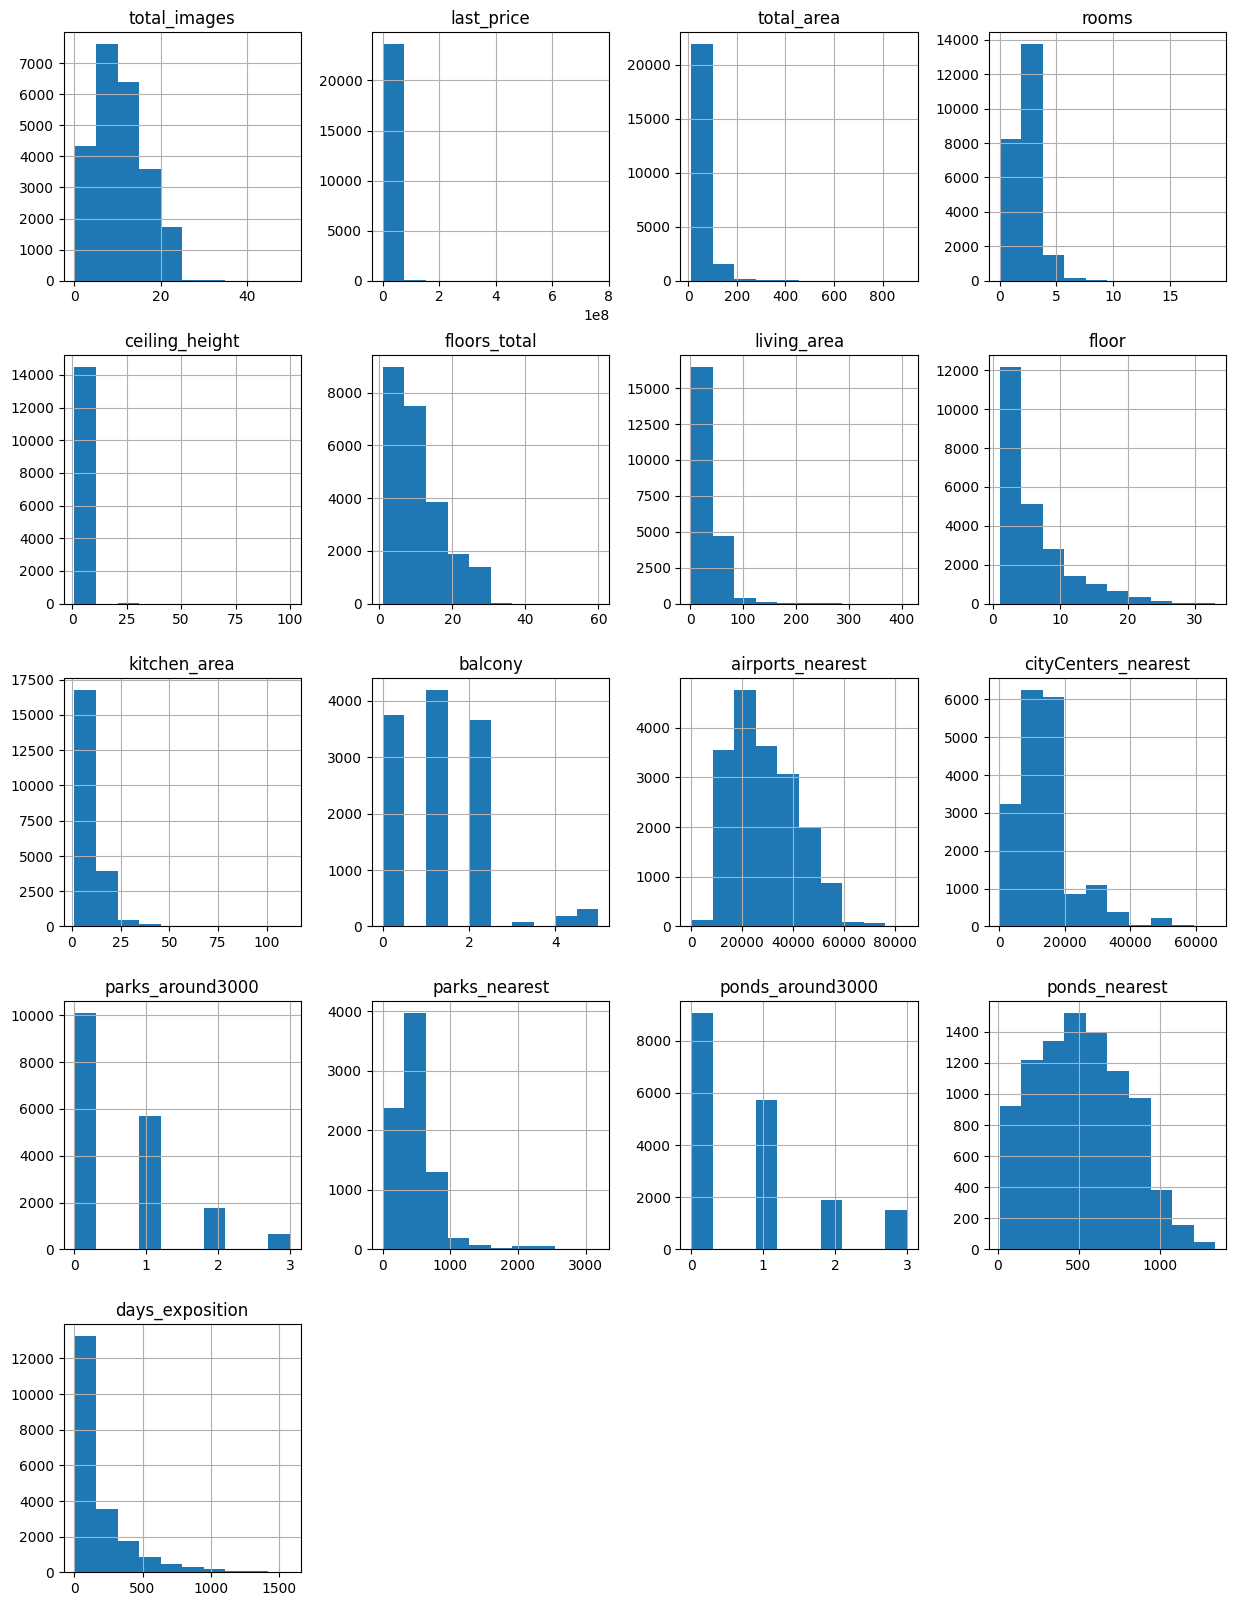

In [1]:
import pandas as pd
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.hist(figsize=(15, 20))
print(data.info())

## Предобработка данных

In [2]:
data.isna().sum()
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски были обнаружены в следующих столбцах:
1. ceiling_height — высота потолков (м)
2. floors_total — всего этажей в доме
3. living_area — жилая площадь в квадратных метрах (м²)
4. is_apartment — апартаменты (булев тип)
5. kitchen_area — площадь кухни в квадратных метрах (м²)
6. balcony — число балконов
7. locality_name — название населённого пункта
8. airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
9. cityCenters_nearest — расстояние до центра города (м)
10. parks_around3000 — число парков в радиусе 3 км
11. parks_nearest — расстояние до ближайшего парка (м)
12. ponds_around3000 — число водоёмов в радиусе 3 км
13. ponds_nearest — расстояние до ближайшего водоёма (м)
14. days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Пропуски в булевом столбце is_apartment скорее всего значат то, что данная позиция не является аппартамантами, поэтому пропуски в этом столбце заменены на False.

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски в столбце balcony заменены на 0.

Пропуски в столбцах parks_around3000 и ponds_around3000 скорее всего значат то, что парковок и водоёмов в радиусе 3 км нет, поэтому пропуски в этих столбцах заполнены 0.

Во всех остальных столбцах логично заполнить пропуски невозможно.

In [3]:
data[['last_price', 'balcony']] = data[['last_price', 'balcony']].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['locality_name'] = data['locality_name'].astype('str')
print(data.dtypes)

total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object


Столбец last_price (цена на момент снятия с публикации) имеет тип float64, но при продаже недвижимости никто не устанавливает цену с копейками в связи с большими суммами, поэтому данный столбец преобразован в int.

Количество балконов в доме в столбце balcony не может быть вещественным числом, поэтому столбец преобразован в int. 

Очевидно, что столбец first_day_exposition (дата публикации) должен быть преобразован из object в  datetime.

Столбец locality_name (название населённого пункта) был преобразован в строку, потому что существующие пропуски мешали обработке столбца на следующем шаге.

In [4]:
data['locality_name'].unique()

def slice_locality(local):
    size = len(local)
    for i in range(size):
        if local[i].isupper():
            return local[i:size]
           
for i, row in data.iterrows():
    data.loc[i, 'locality_name'] = slice_locality(row['locality_name'])
    
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Чтобы устранить неявные дубликаты в столбце locality_name (название населённого пункта), было принято решение написать функцию, которая делает срез строки, начиная с первой заглавной буквы

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,23699.000000,23699.000000,8079.000000,23699.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,10886.426896,0.469049,490.804555,0.590911,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,9634.613697,0.748534,342.317995,0.883999,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,2242.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,11247.000000,0.000000,455.000000,0.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,15248.500000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [6]:
print('Квартиры площадью более 300 м²:', data.query('total_area > 300')['total_area'].count())

Квартиры площадью более 300 м²: 61


Квартир со слишком большой площадью более 300 м² немного и  их можно удалить.

In [7]:
data.drop(index=data.query('total_area > 300').index, inplace=True)

Квартиры с количеством комнат больше 10 также можно удалить.

In [8]:
data.drop(index=data.query('rooms > 10').index, inplace=True)

Оставим квартиры с высотой потолков от 2 до 5 м., остальные будем считать аномалиями и удалим.

In [9]:
data.drop(index=data.query('ceiling_height < 2 and ceiling_height > 5').index,inplace=True)

In [10]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.5 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.  ,   2.79,
         2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,   4.7 ,
         2.4 ,   3.38,   3.01,   3.65,   3.18,   3.35,   2.3 ,   3.57,
         2.48,   2.62,   2.82,   3.98,   2.63,   3.83,   3.52,   3.95,
         3.75,   2.88,   3.67,   3.87,   3.66,   3.85,   4.19,   3.24,
         4.8 ,   4.5 ,   4.2 ,   3.36,   3.86,  32.  ,   3.08,   3.68,
         3.07,   3.37,   3.09,   8.  ,   3.16,   3.26,   3.34,   2.81,
      

In [11]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] * 0.1 
data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.5 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.  ,  2.79,
        2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,  4.7 ,  2.4 ,
        3.38,  3.01,  3.65,  3.18,  3.35,  2.3 ,  3.57,  2.48,  2.62,
        2.82,  3.98,  2.63,  3.83,  3.52,  3.95,  3.75,  2.88,  3.67,
        3.87,  3.66,  3.85,  4.19,  3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,
        3.86,  3.08,  3.68,  3.07,  3.37,  3.09,  8.  ,  3.16,  3.26,
        3.34,  2.81,  3.44,  2.97,  3.14,  4.37,  2.68,  3.9 ,  3.22,
        3.27,  4.1 ,  2.93,  3.46,  2.4 ,  3.47,  3.33,  3.63,  3.32,
        1.2 ,  8.3 ,

In [12]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено.

<b> Вывод </b>

1. Изучена основная информация о предоставленных данных. В данных очень много пропусков, часть из них была заполнена значениями, которые вероятнее всего должны  быть там.
2. Столбцы last_price, balcony, first_day_exposition, locality_name были приведены к корректному типу данных.	 
3. Названия населенных пунктов имели неявные дубликаты, что бы устранено.
4. Осуществлена проверка на аномалии, в ходе которой вероятнее всего были обнаружены ошибки заполнения.
5. Явных дубликатов в данных не обнаружено.


## Посчитаем и добавим в таблицу новые столбцы

In [13]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

def floor_category_digit(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 1
    elif floor == floors_total:
        return 0
    else:
        return 2
    
data['floor_category'] = data.apply(floor_category, axis = 1)
data['floor_category_digit'] = data.apply(floor_category_digit, axis = 1)
data['cityCenters_nearestKm'] = data['cityCenters_nearest'] / 1000 
data['cityCenters_nearestKm'] = data['cityCenters_nearestKm'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23634 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23634 non-null  int64         
 1   last_price              23634 non-null  int32         
 2   total_area              23634 non-null  float64       
 3   first_day_exposition    23634 non-null  datetime64[ns]
 4   rooms                   23634 non-null  int64         
 5   ceiling_height          14461 non-null  float64       
 6   floors_total            23548 non-null  float64       
 7   living_area             21744 non-null  float64       
 8   floor                   23634 non-null  int64         
 9   is_apartment            23634 non-null  bool          
 10  studio                  23634 non-null  bool          
 11  open_plan               23634 non-null  bool          
 12  kitchen_area            21369 non-null  float6

## Проведем исследовательский анализ данных

array([[<Axes: title={'center': 'total_area'}>]], dtype=object)

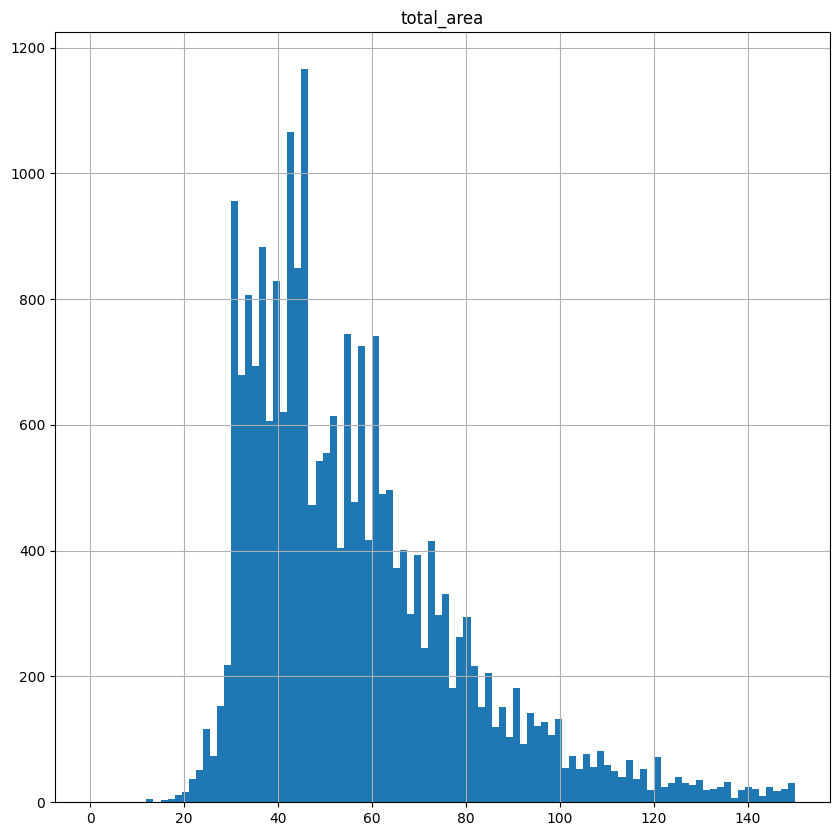

In [14]:
data.hist('total_area', bins=100, figsize=(10, 10), range = (0, 150))

Наблюдаем наибольшее количество квартир примерно с 30-50 м². Квартир с площадью более 100 м². очень мало.

array([[<Axes: title={'center': 'living_area'}>]], dtype=object)

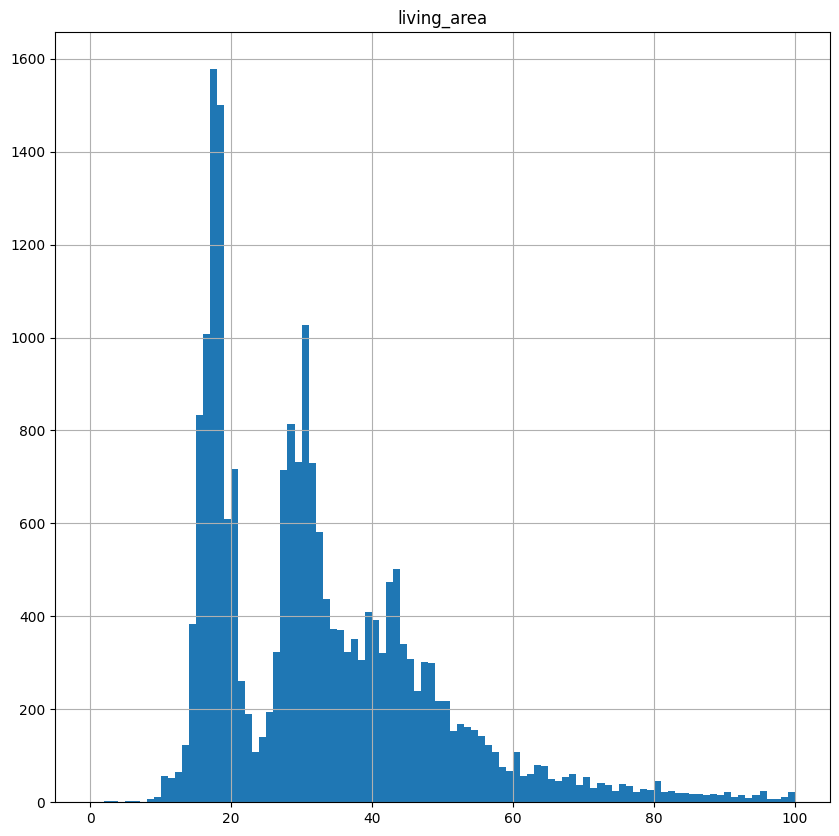

In [15]:
data.hist('living_area', bins=100, range = (0, 100), figsize=(10, 10))

В жилой площади наблюдаем два пика - на 17 м² и на 30 м² 

array([[<Axes: title={'center': 'kitchen_area'}>]], dtype=object)

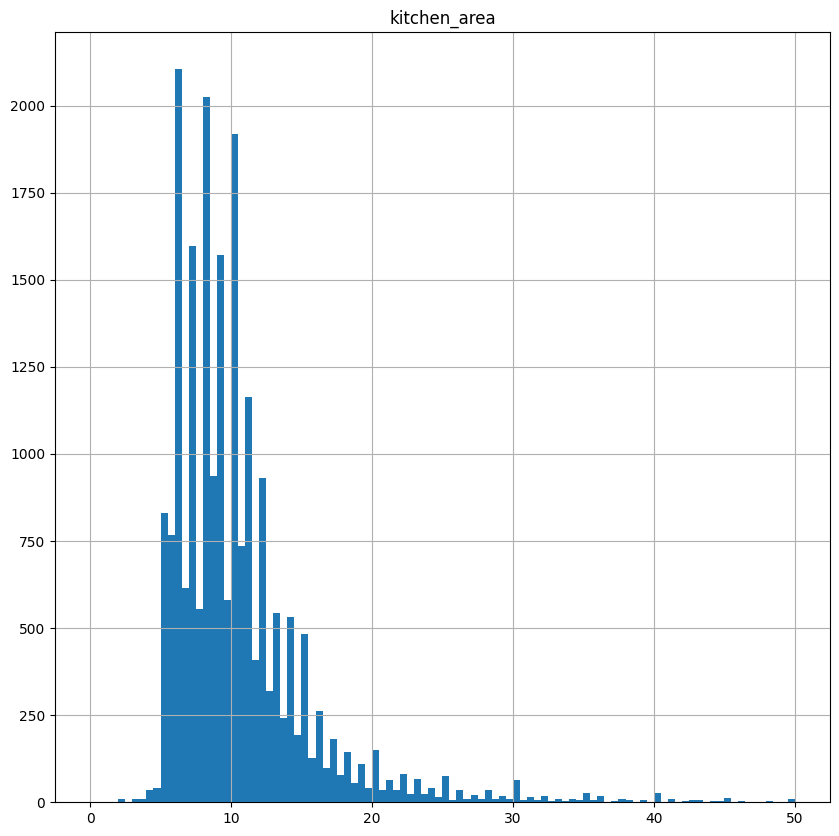

In [16]:
data.hist('kitchen_area', bins=100, range = (0, 50), figsize=(10, 10))

Наиболее популярная площадь кухни с 5 м² до 10 м².

array([[<Axes: title={'center': 'last_price'}>]], dtype=object)

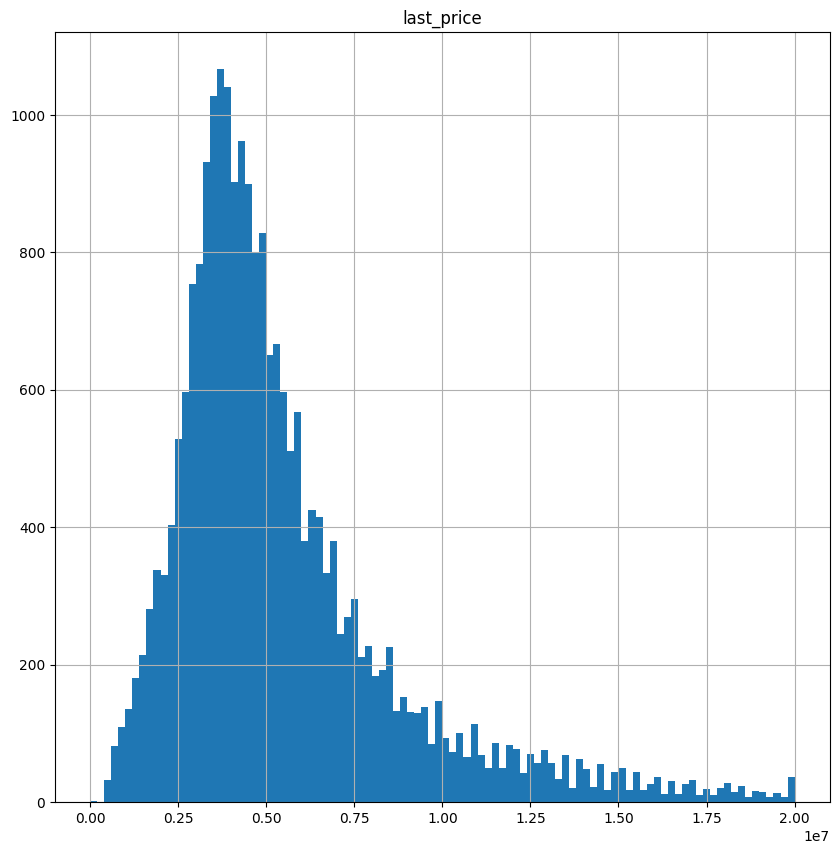

In [17]:
data.hist('last_price', bins=100, range=(0, 20000000), figsize=(10, 10))

Чаще всего встречаемая цена на квартиры от 2.5 млн. до 5 млн.

array([[<Axes: title={'center': 'rooms'}>]], dtype=object)

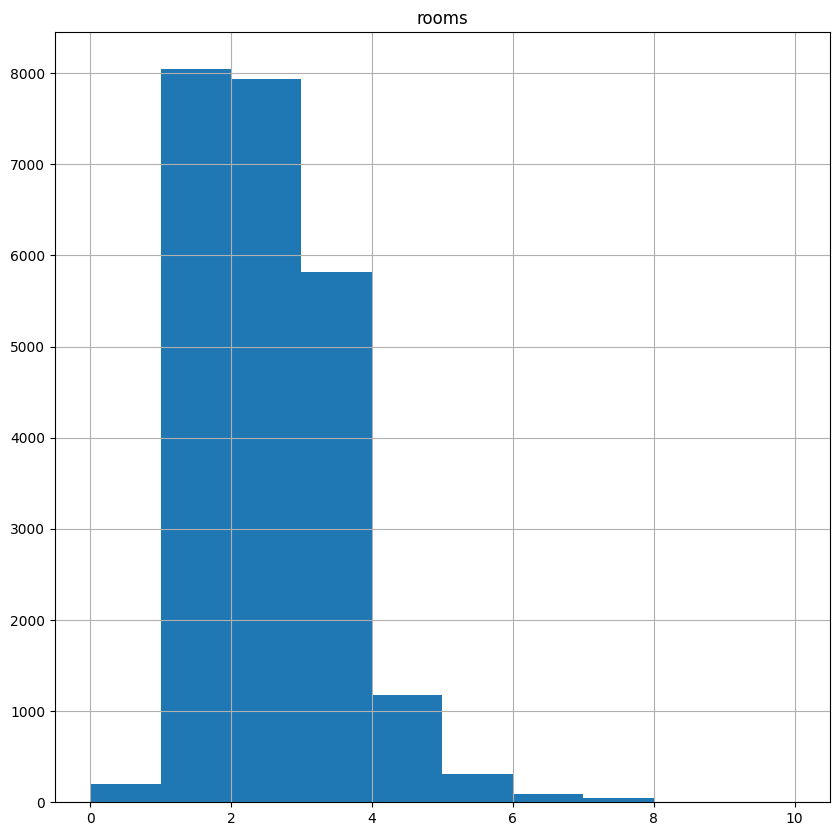

In [18]:
data.hist('rooms', bins=10, figsize=(10, 10))

Больше всего 1-3 комнатных квартир.

array([[<Axes: title={'center': 'ceiling_height'}>]], dtype=object)

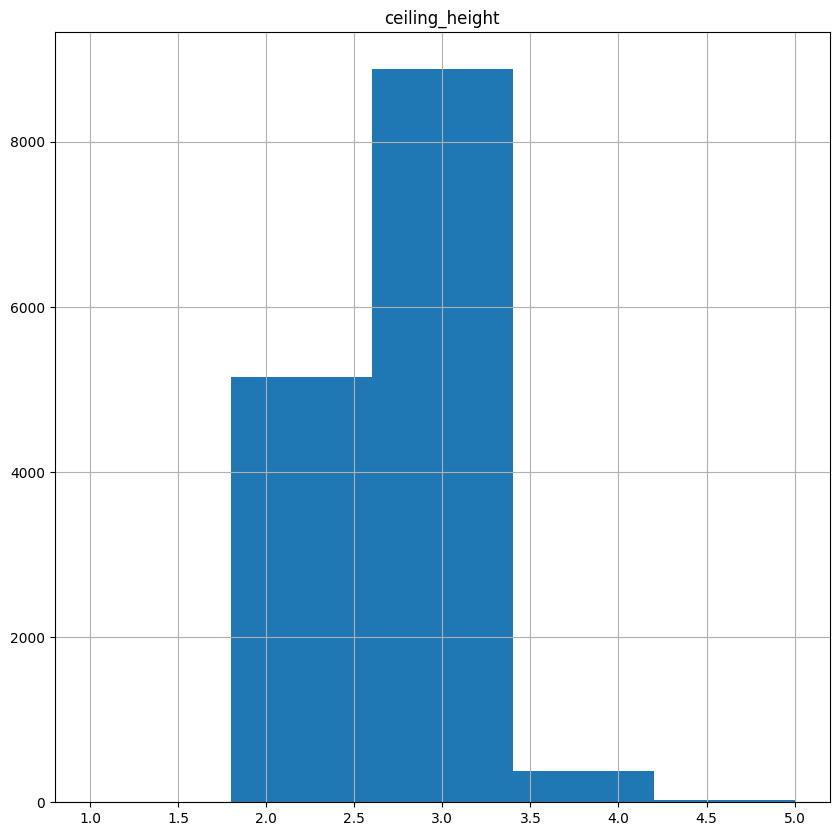

In [19]:
data.hist('ceiling_height', bins=5, range=(1, 5), figsize=(10, 10))

Наиболее популярная высота потолков от  2.5 м до 3.5 м.

array([[<Axes: title={'center': 'floor'}>]], dtype=object)

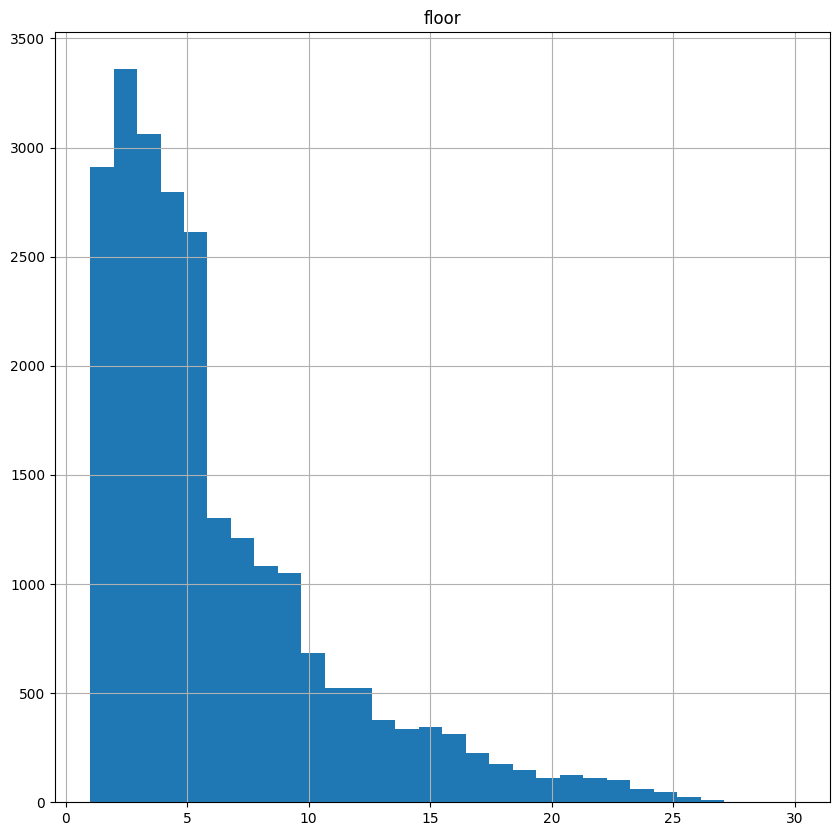

In [20]:
data.hist('floor', bins=30, range=(1, 30), figsize=(10, 10))

Больше всего квартир с 1 по 5 этаж. 

<Axes: xlabel='floor_category'>

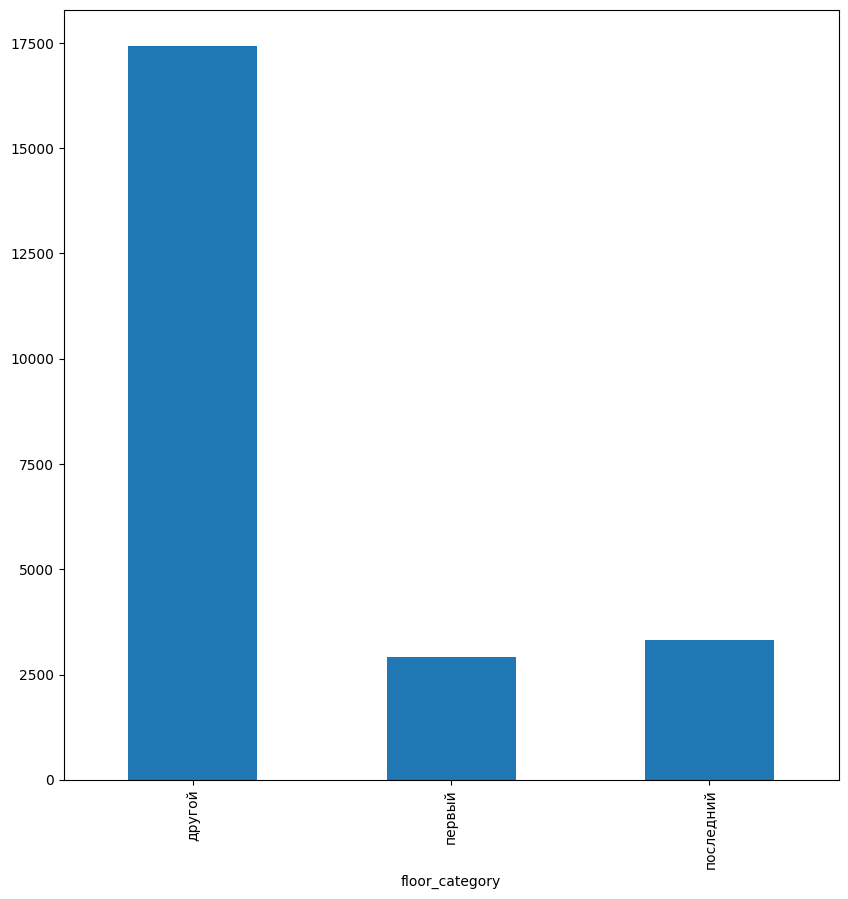

In [21]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', figsize=(10, 10))

Больше всего квартир на "другом" этаже. Первых и последних этажей примерно одинакого мало.

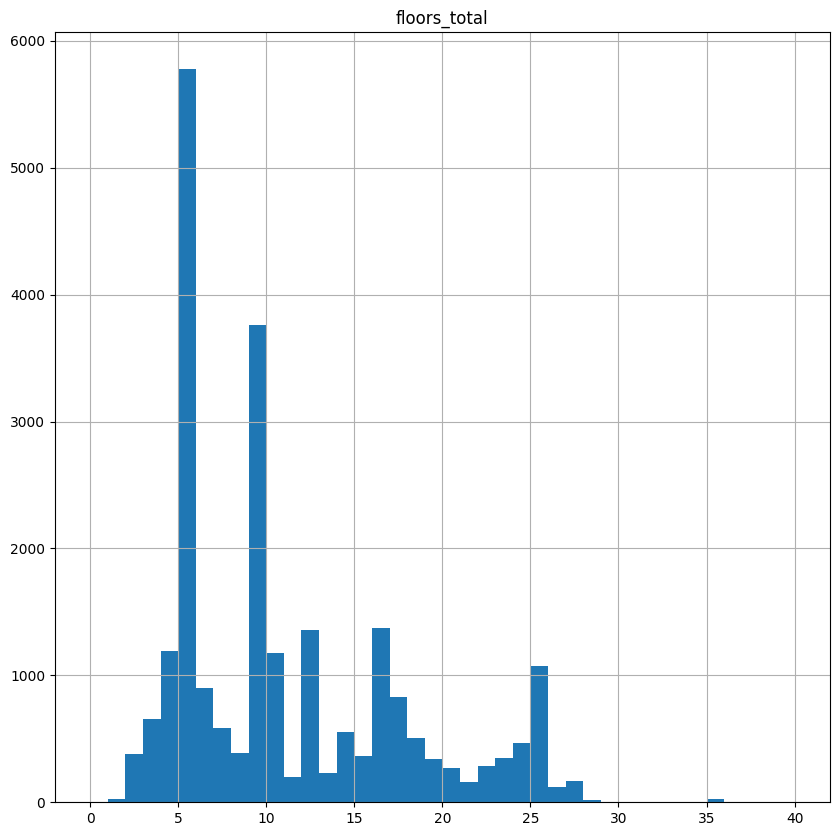

In [22]:
data.hist('floors_total', bins = 40, range=(0, 40), figsize=(10, 10));

Видим явные пики: 5-этажная застройка, 9-этажная застройка, и небольшие пики более высоких новостроек.

array([[<Axes: title={'center': 'cityCenters_nearest'}>]], dtype=object)

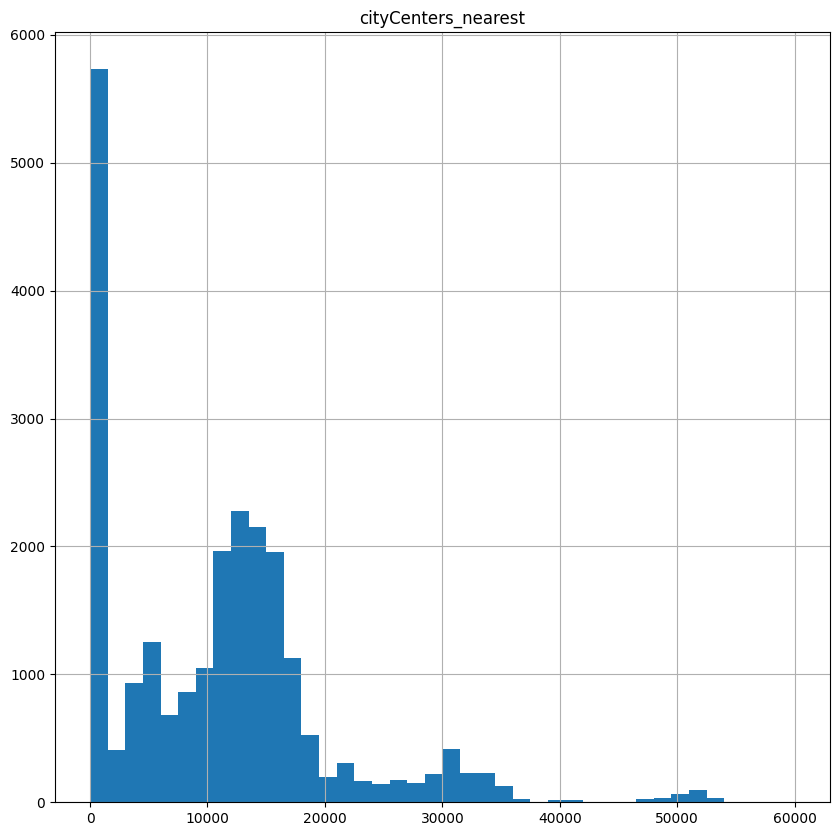

In [23]:
data.hist('cityCenters_nearest', bins = 40, range=(0, 60000), figsize = (10, 10))

Здесь наблюдаем 3 пика, один большой, около 1 км, 5 км, и от 10 км.

array([[<Axes: title={'center': 'airports_nearest'}>]], dtype=object)

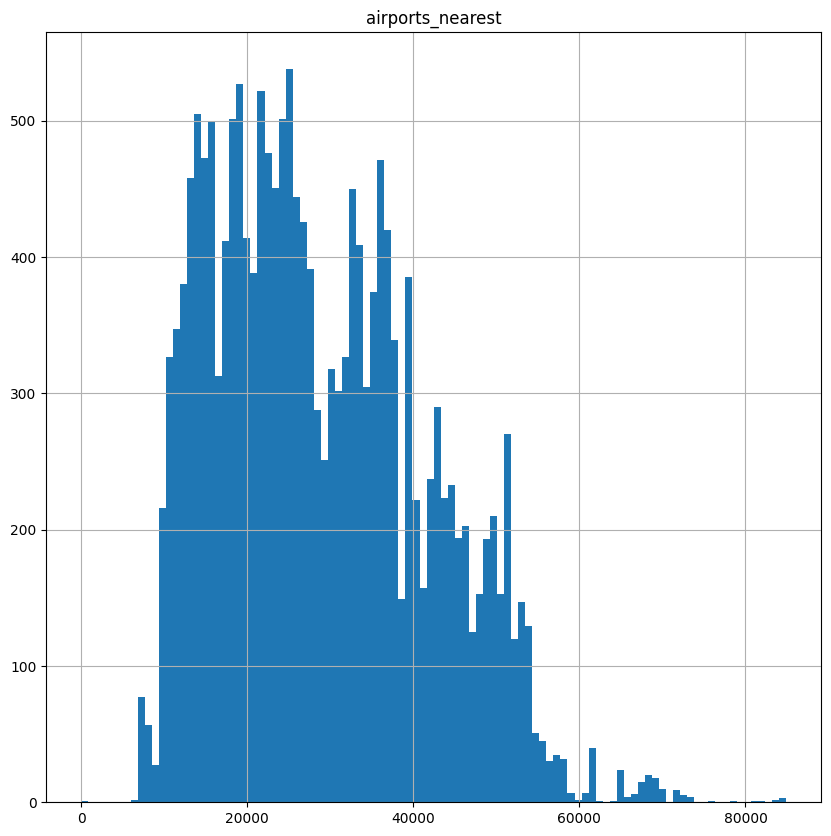

In [24]:
data.hist('airports_nearest', bins=100, figsize = (10, 10))

Наиболее распространненное растояние до аэропорта 10 - 40 км.

array([[<Axes: title={'center': 'parks_nearest'}>]], dtype=object)

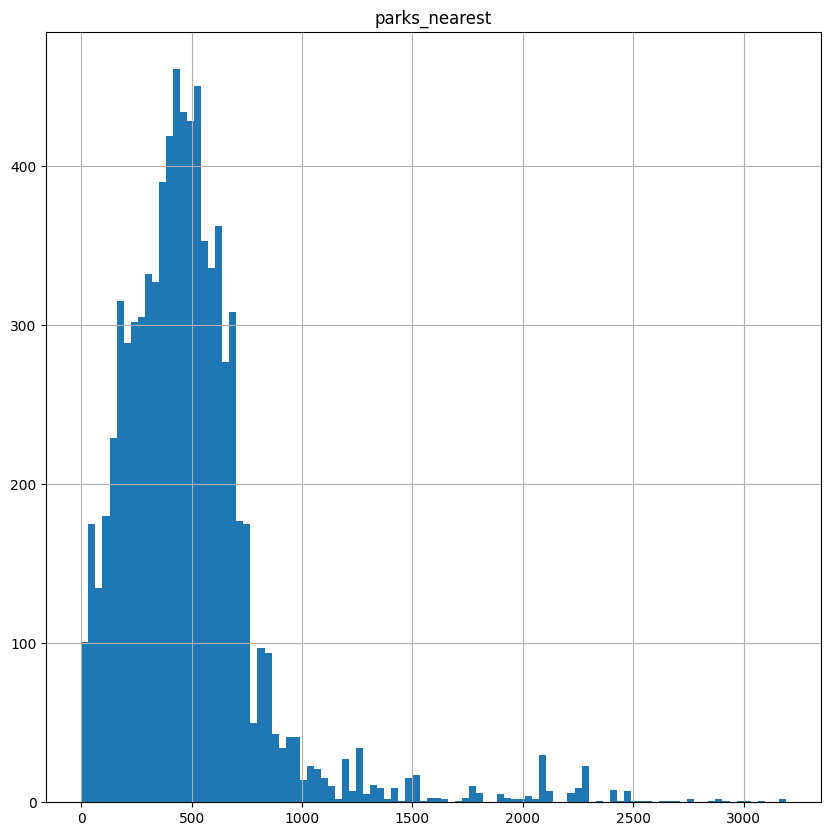

In [25]:
data.hist('parks_nearest', bins=100, figsize = (10, 10))

Больше всего квартир с парками на расстоянии около 500 м.

array([[<Axes: title={'center': 'weekday_exposition'}>]], dtype=object)

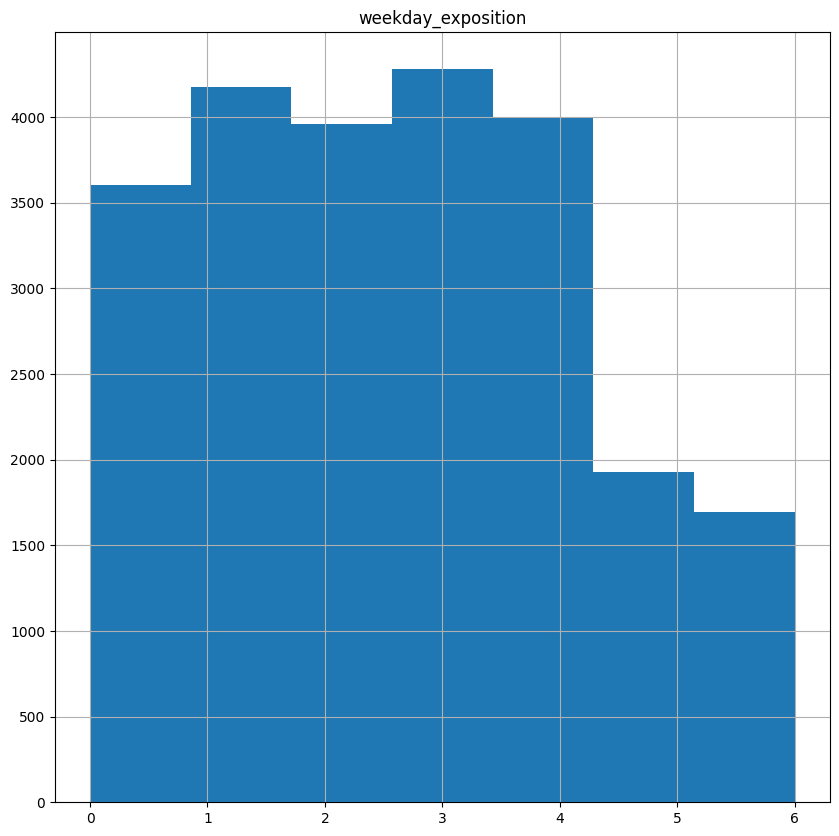

In [26]:
data.hist('weekday_exposition', bins=7, figsize = (10, 10))

Видим провал в публикации объявлений в субботу и воскресенье.

array([[<Axes: title={'center': 'month_exposition'}>]], dtype=object)

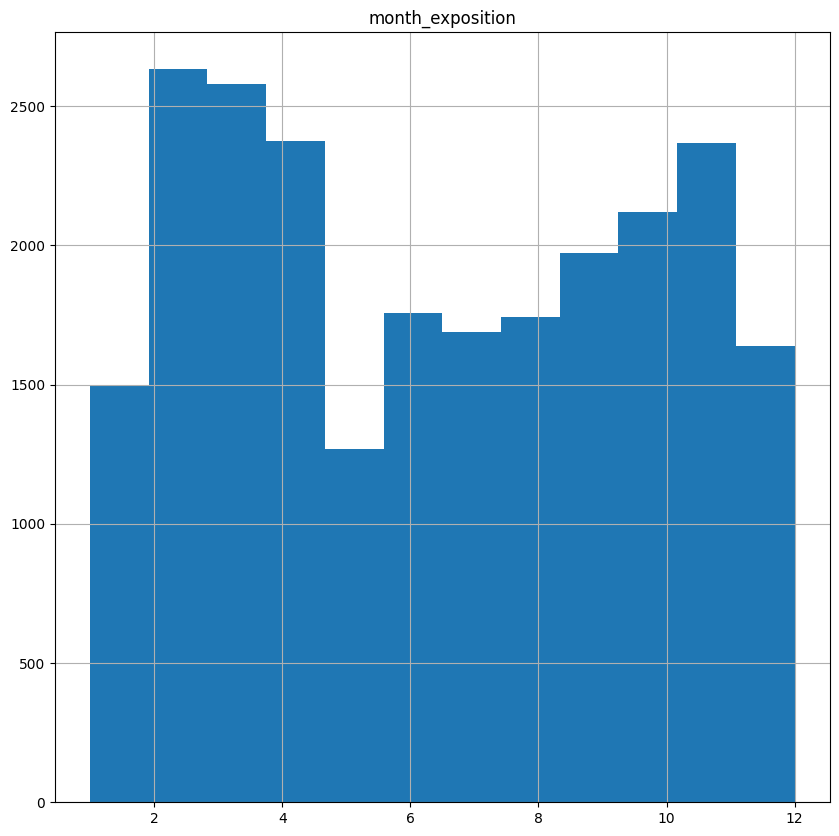

In [27]:
data.hist('month_exposition', bins=12, figsize = (10, 10))

С февраля по апрель наблюдалась повышенная активность. Также был рост активности с июля по ноябрь. Провалы в декабре, январе и мае.

### Изучение сроков продаж квартир

<Axes: >

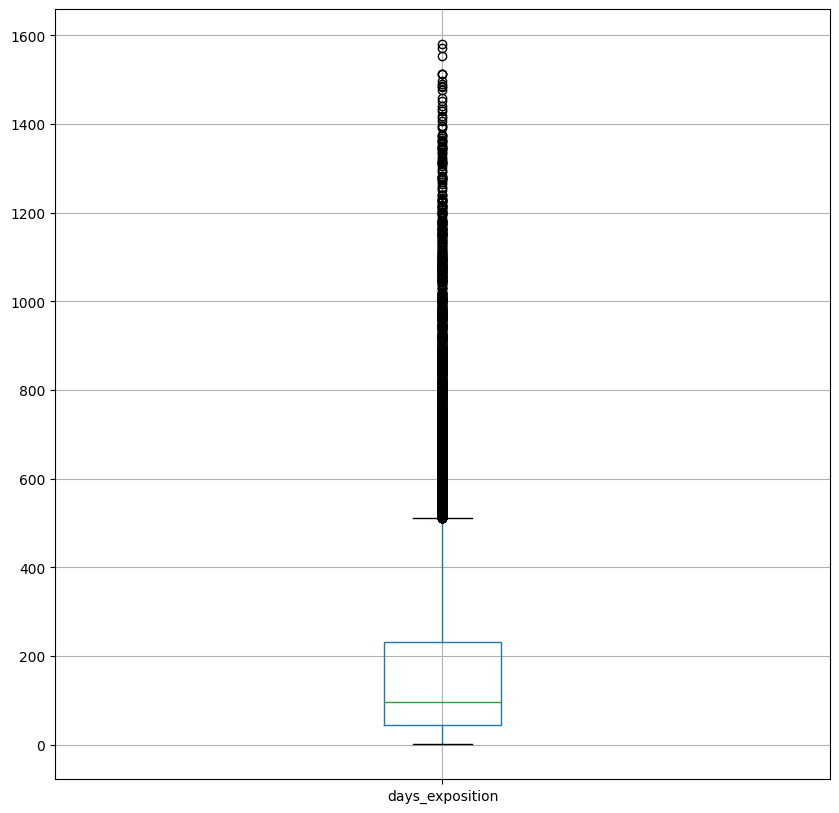

In [28]:
data.boxplot(column=['days_exposition'], figsize = (10, 10))

In [29]:
print('Среднее время продажи квартиры в днях:', int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:', int(data['days_exposition'].median()))
data['days_exposition'].describe()

Среднее время продажи квартиры в днях: 180
Медианное время продажи квартиры в днях: 95


count    20467.000000
mean       180.565007
std        219.323813
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Cреднее время продажи квартиры составляет 180 день. Но если взять медиану, то это уже 95 дней, почти в два раза меньше. Это связано с тем, что есть часть квартир, которые продавались годами.
Быстрыми можно считать продажи до 95 дней, а необычно долгими - свыше 180 дней.

### Факторы, которые больше всего влияют на общую (полную) стоимость объекта

Корреляция между last_price и total_area составляет: 0.6764219243369382
Корреляция между last_price и living_area составляет: 0.586762486537319
Корреляция между last_price и kitchen_area составляет: 0.5156493448019163
Корреляция между last_price и rooms составляет: 0.39422668715833686
Корреляция между last_price и floor_category_digit составляет: 0.03150199795608547
Корреляция между last_price и days_exposition составляет: 0.10645744882871731
Корреляция между last_price и month_exposition составляет: 0.0016895262850452654
Корреляция между last_price и year_exposition составляет: -0.048924587876020546


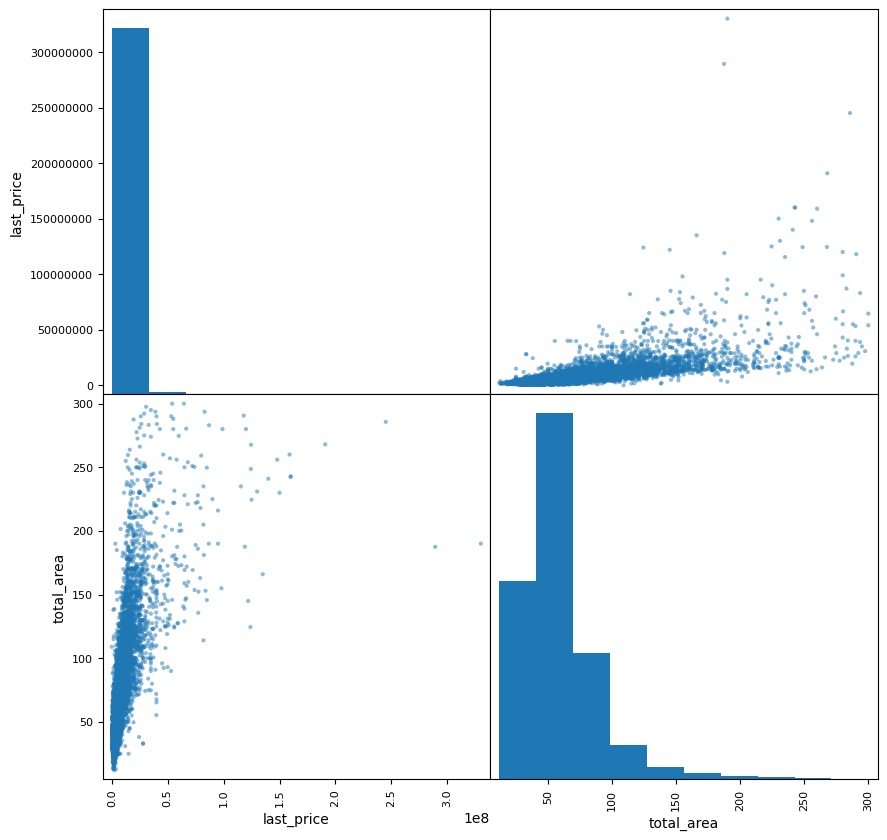

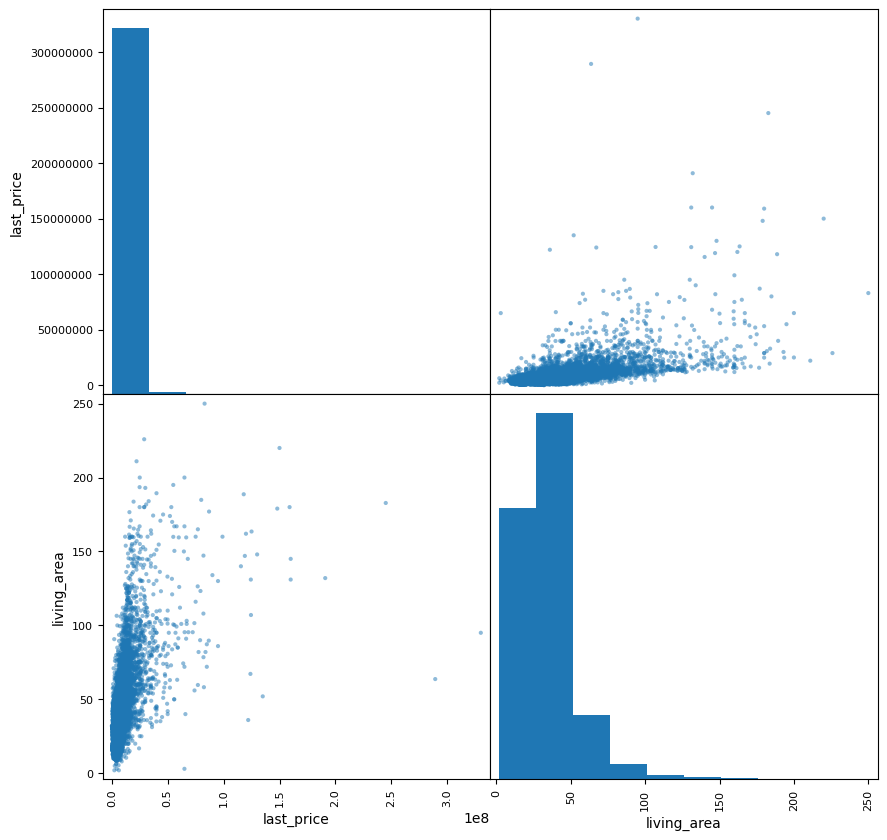

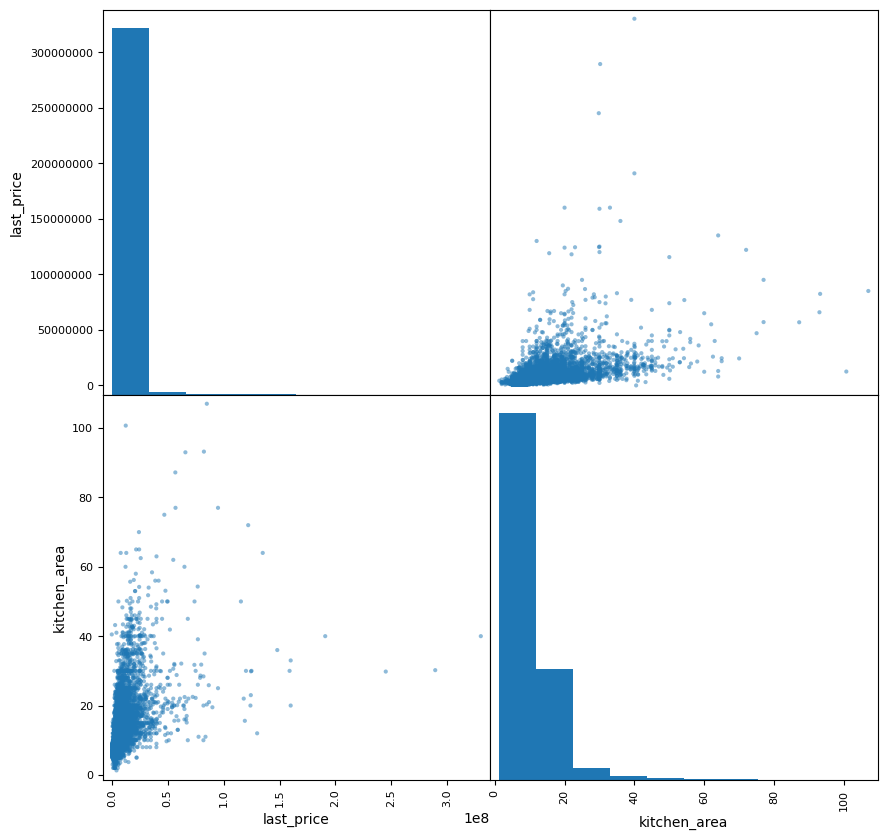

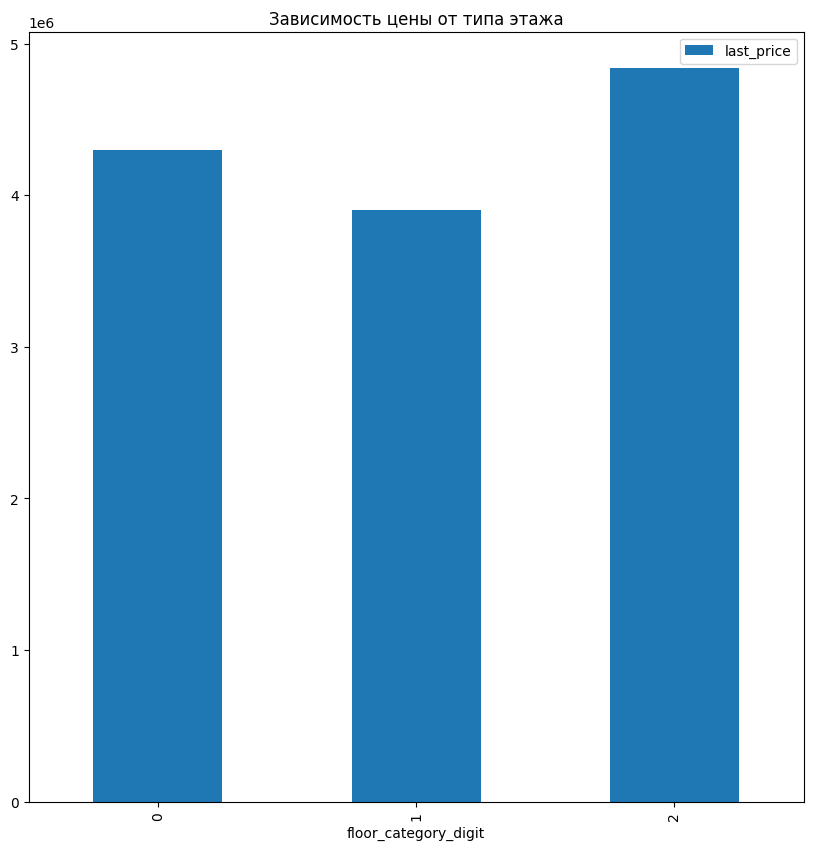

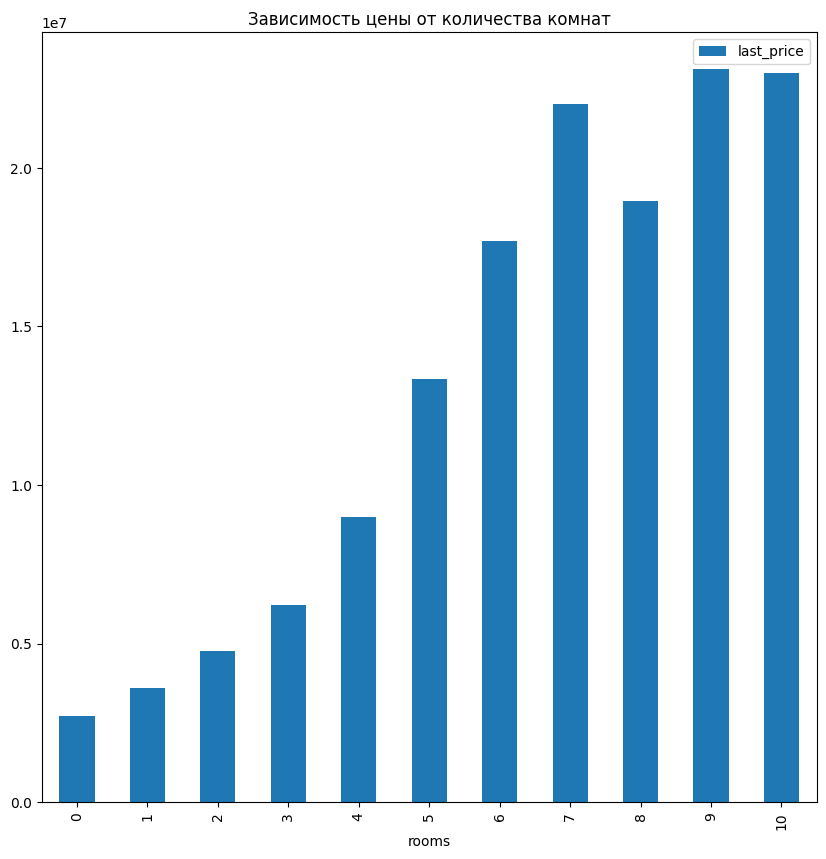

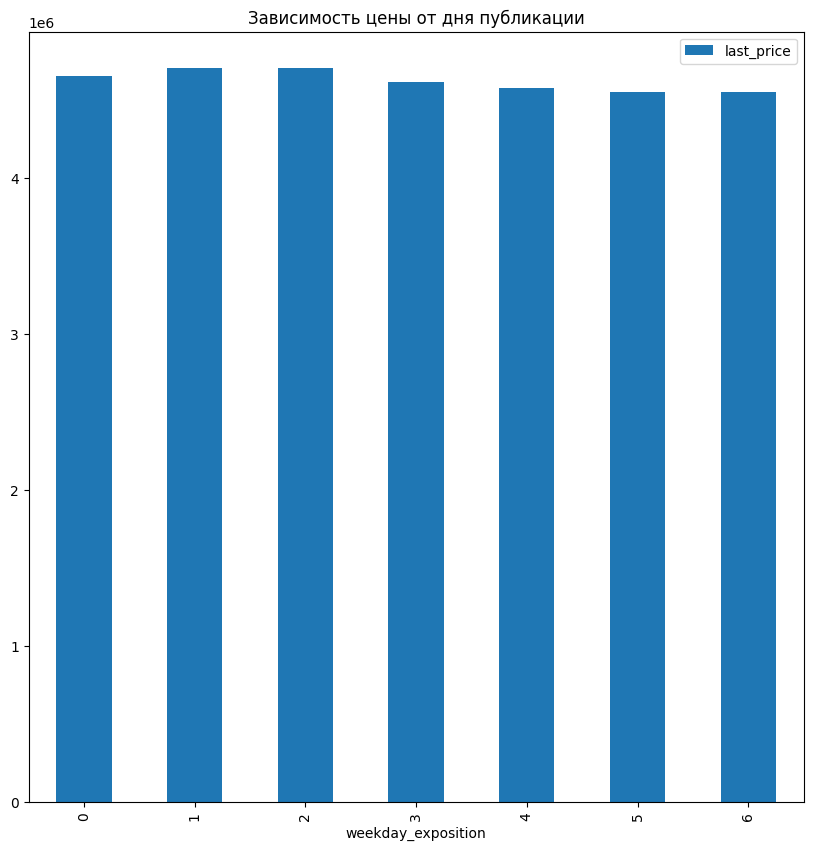

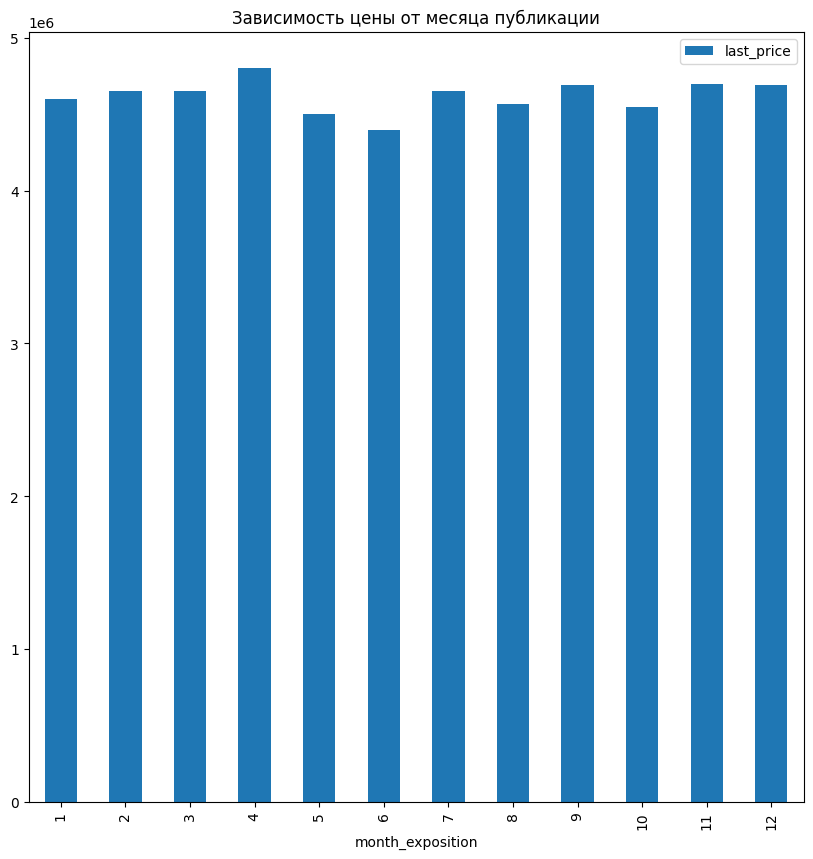

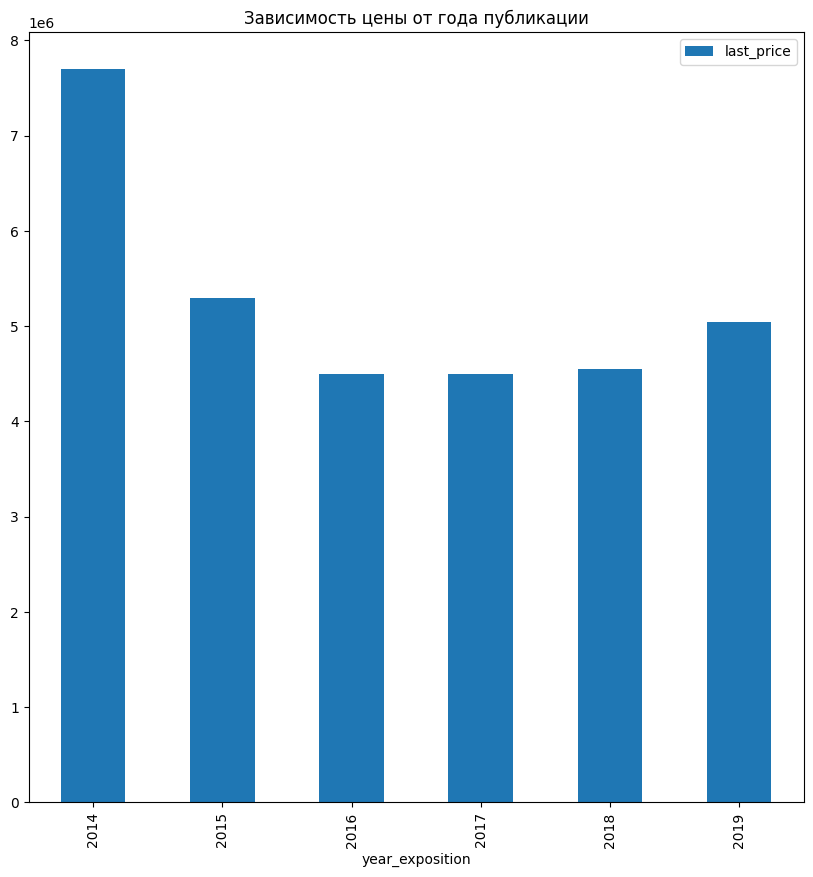

In [30]:
list_of_factors = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floor_category_digit',
                  'days_exposition',
                  'month_exposition',
                  'year_exposition']

for entry in list_of_factors:
    df = data[['last_price', entry]]
    if entry in ['total_area',
                 'living_area',
                 'kitchen_area']:
        pd.plotting.scatter_matrix(df, figsize = (10, 10))
    print('Корреляция между last_price и', entry, 'составляет:', data['last_price'].corr(data[entry]))

data.pivot_table(index='floor_category_digit', values='last_price', aggfunc='median').plot(kind='bar', title = 'Зависимость цены от типа этажа', figsize = (10, 10));
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(kind='bar', title = 'Зависимость цены от количества комнат', figsize = (10, 10));
data.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median').plot(kind='bar', title = 'Зависимость цены от дня публикации', figsize = (10, 10));
data.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(kind='bar', title = 'Зависимость цены от месяца публикации', figsize = (10, 10));
data.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot(kind='bar', title = 'Зависимость цены от года публикации', figsize = (10, 10));

Больше всего полная стоимость объекта зависит от общей площади. Далее следуют жилая площадь, площадь кухни и количество комнат. Также цены снизились в 2015 году. Всеми остальными факторами можно пренебречь.

### Подсчёт средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

                 count           mean
locality_name                        
Санкт-Петербург  15660  114380.210225
Мурино             590   86087.512050
Кудрово            472   95324.930544
Шушары             440   78677.364217
Всеволожск         398   68654.473986
Пушкин             367  103130.851744
Колпино            337   75333.295801
Парголово          327   90175.913458
Гатчина            307   68746.146763
Выборг             237   58141.909153


<Axes: ylabel='locality_name'>

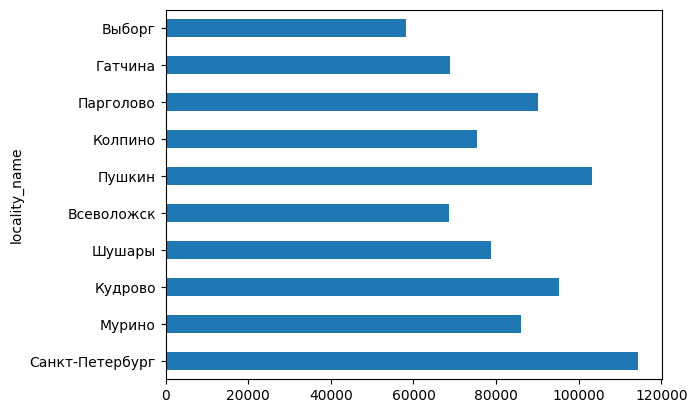

In [31]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
print(locality_pivot_table)
locality_pivot_table['mean'].plot(kind='barh')

Самая высокая стоимость квадратного метра в Санкт-Петербурге, а самая низкая в Выборге.

### Вычисление средней цены каждого километра

                         last_price
cityCenters_nearestKm              
0                      1.877962e+07
1                      1.813646e+07
2                      1.461901e+07
3                      1.148081e+07
4                      1.262541e+07
5                      1.364452e+07
6                      1.381737e+07
7                      1.131676e+07
8                      8.445272e+06
9                      6.407080e+06
10                     6.357295e+06
11                     5.963656e+06
12                     5.972820e+06
13                     6.004135e+06
14                     5.754757e+06
15                     5.514479e+06
16                     5.468224e+06
17                     4.865574e+06
18                     5.198136e+06
19                     4.678756e+06
20                     6.365864e+06
21                     5.183239e+06
22                     5.425513e+06
23                     4.126867e+06
24                     3.862235e+06
25                     4.014

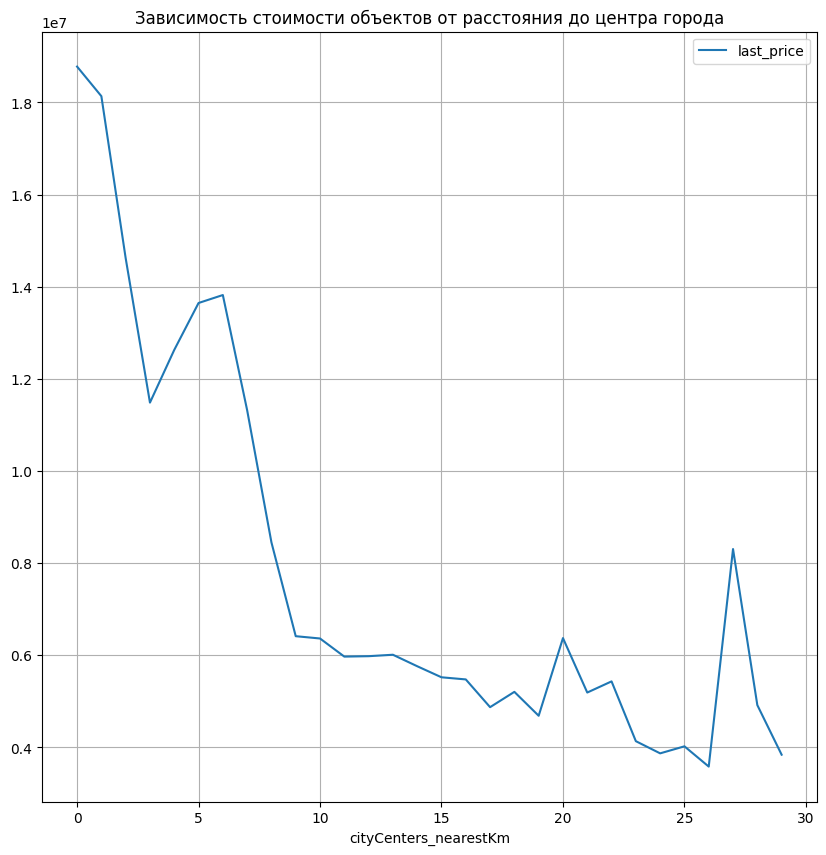

In [32]:
saint_petersburg = pd.DataFrame(data.loc[data['locality_name'] == "Санкт-Петербург"])
saint_petersburg.reset_index()
price = saint_petersburg.pivot_table(index='cityCenters_nearestKm', values='last_price')
print(price)
price.plot(figsize = (10, 10), grid = True, title = 'Зависимость стоимости объектов от расстояния до центра города');

Вычислена средняя цена каждого километра. Стоимость объектов в самом центре Санкт-Петербурга самая высокая, далее цена постепенно снижается до 3 км от центра города, с 3 км до 6 км резко возрастает, далее снижается с незначительными всплесками. На 26 км идет резкий рост более чем в 2 раза, затем снижение до предшествующих значений.

## Общий вывод

В ходе выполнения проектной работы была осуществлена предобработка данных: обработаны пропущенные значения там, где это необходимо, заменены типы данных на необходимые. Посчитаны и добавлены в таблицу цены одного квадратного метра жилья, день, месяц и год публикации объявления, тип этажа квартиры («первый», «последний», «другой»), а также расстояние в км до центра города. Изучены следующие параметры на наличие аномалий: площадь, цена, число комнат, высота потолков. 



Найдены  интересные особенности и зависимости, которые существуют на рынке недвижимости:

* Самая популярная на рынке недвижимость: 1-2 комнатная квартира на 2-8 этаже с площадью 30-50 м² и высотой потолков от 2.5 м до 3.5 м., в которой жилая площадь 17-30 м², а площадь кухни 5-10 м². Цена: от 2.5 млн. до 5 млн. рублей.
* Быстрыми можно считать продажи недвижимости до 95 дней, а необычно долгими - свыше 180 дней.
* Больше всего полная стоимость объекта зависит от общей площади. Далее следуют жилая площадь, площадь кухни и количество комнат.
* Самая высокая стоимость квадратного метра в Санкт-Петербурге, а самая низкая в Выборге.
* Стоимость объектов в самом центре Санкт-Петербурга самая высокая, далее цена постепенно снижается до 3 км от центра города, с 3 км до 6 км резко возрастает, далее снижается с незначительными всплесками. На 26 км идет резкий рост более чем в 2 раза, затем снижение до предшествующих значений.